In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
import cv2
import random as rand

In [23]:
INPUT, GEN_LIN_1, GEN_LIN_2, OUT = 28**2, 16**2, 22**2, 28**2
CLASSES = 2

class Discriminator(torch.nn.Module):
    '''
     Network to discriminate between real and fake images.
    '''
    def __init__(self):
        super().__init__()
        self.l_one = torch.nn.Conv2d(1, 8, kernel_size=12, stride=1)
        self.l_two = torch.nn.Conv2d(8, 16, kernel_size=12, stride=1)
        self.l_three = torch.nn.Conv2d(16, 2, kernel_size=1, stride=1)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.l_one(x))
        x = F.relu(self.l_two(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.l_three(x).view(-1, CLASSES)
        return x

class Generator(torch.nn.Module):
    '''
     Network to generate fake images
    '''
    def __init__(self):
        super().__init__()
        self.l_one = torch.nn.Conv2d(1, 3, kernel_size=4, stride=1) 
        self.l_two = torch.nn.Conv2d(3, 12, kernel_size=4, stride=1) 
        self.l_three = torch.nn.Conv2d(12, 24, kernel_size=4, stride=1) 
        self.l_four = torch.nn.Conv2d(24, 1, kernel_size=4, stride=1)
        self.l_five = torch.nn.Linear(GEN_LIN_1, GEN_LIN_2)
        self.l_six = torch.nn.Linear(GEN_LIN_2, OUT)
        
    def forward(self, x):
        x = x.view(-1, 28, 28).unsqueeze(1)
        x = F.relu(self.l_one(x))
        x = F.relu(self.l_two(x))
        x = F.relu(self.l_three(x))
        x = F.relu(self.l_four(x))
        x = x.squeeze().view(-1, 16**2) # flatten volume
        x = F.relu(self.l_five(x))
        x = F.relu(self.l_six(x))
        return x.view(-1, 28, 28)

In [24]:
images = np.load('minst_test_images.npy')
N = len(images)
images = (images.reshape((N, 28, 28)) / 255).astype(np.float_) # reshape data to 28 x 28 image and normalize
loss = torch.nn.CrossEntropyLoss()

In [25]:
def train_disc(batch_size):
    # train Discriminator on real data
    dis_model.zero_grad()
    perm = np.random.choice(N, size=batch_size, replace=False)
    real_data = Variable(torch.Tensor(images[perm]))
    real_out = dis_model(real_data)
    real_error = loss(real_out, Variable(torch.LongTensor(np.ones(batch_size, dtype=int))))
    real_error.backward()
    # train Discriminator on generated data
    input_ = Variable(torch.Tensor(np.random.randn(batch_size, INPUT)))
    fake_data = gen_model(input_).detach()
    fake_out = dis_model(fake_data)
    fake_error = loss(fake_out, Variable(torch.LongTensor(np.zeros(batch_size, dtype=int))))
    fake_error.backward()
    dis_optim.step()
    return real_error.data[0], fake_error.data[0]

def train_gen(batch_size):
    gen_model.zero_grad()
    input_ = Variable(torch.Tensor(np.random.randn(batch_size, INPUT)))
    gen_data = gen_model(input_)
    gen_out = dis_model(gen_data)
    gen_error = loss(gen_out, Variable(torch.LongTensor(np.ones(batch_size, dtype=int))))
    gen_error.backward()
    gen_optim.step()
    return gen_error.data[0]

def get_dis_class():
    dis_model.eval()
    perm = np.random.choice(N, size=100, replace=False)
    data = Variable(torch.Tensor(images[perm]))
    max_, out = torch.max(dis_model(data), dim=1)
    return (out.data.numpy() == np.ones(100)).astype(float).mean()

def get_gen_class():
    gen_model.eval()
    dis_model.eval()
    input_ = Variable(torch.Tensor(np.random.randn(100, INPUT)))
    fake_data = gen_model(input_)
    max_, out = torch.max(dis_model(fake_data), dim=1)
    return (out.data.numpy() == np.ones(100)).astype(float).mean()

In [26]:
lr = 1e-5
gen_model = Generator()
dis_model = Discriminator()
gen_optim = torch.optim.Adam(gen_model.parameters(), lr)
dis_optim = torch.optim.Adam(dis_model.parameters(), lr)

Iteration 0


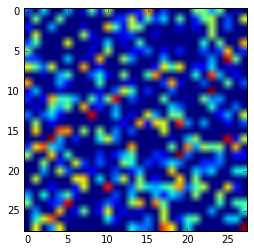

Iteration 1000


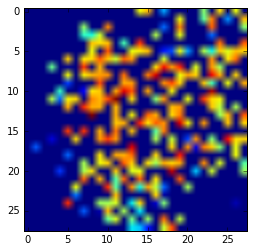

Iteration 2000


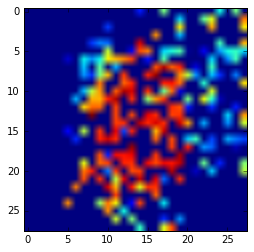

Iteration 3000


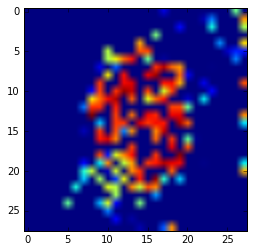

Iteration 4000


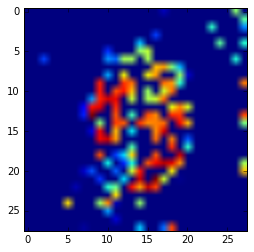

Iteration 5000


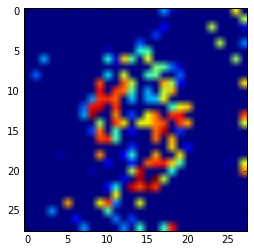

Iteration 6000


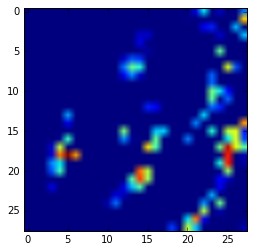

Iteration 7000


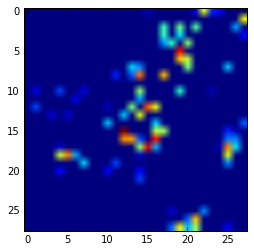

Iteration 8000


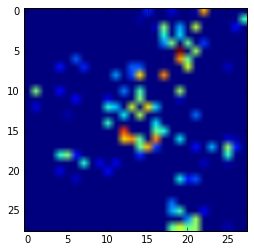

Iteration 9000


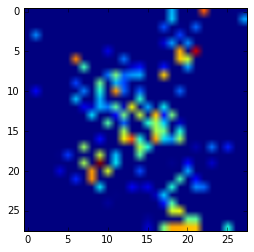

Iteration 10000


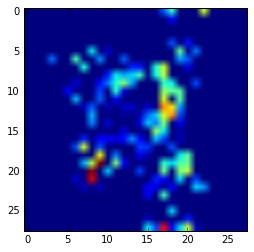

Iteration 11000


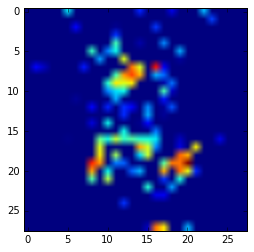

Iteration 12000


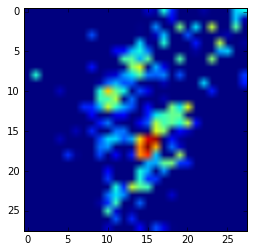

Iteration 13000


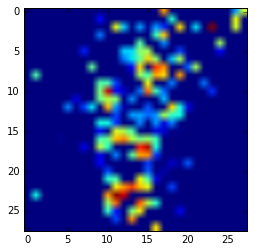

Iteration 14000


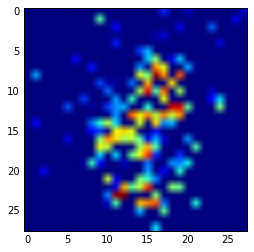

Iteration 15000


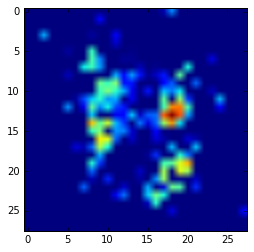

Iteration 16000


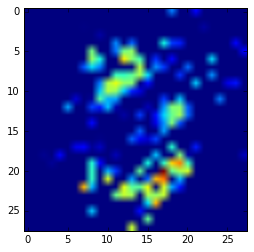

Iteration 17000


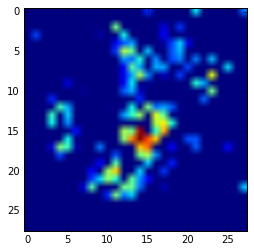

Iteration 18000


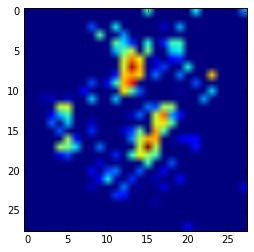

Iteration 19000


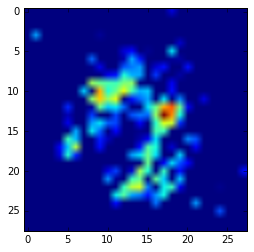

Iteration 20000


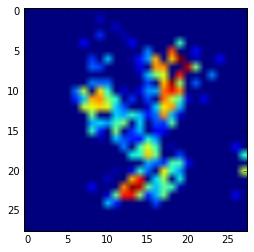

Iteration 21000


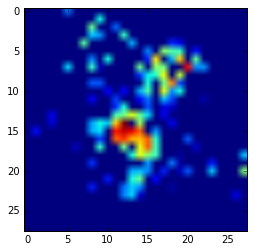

Iteration 22000


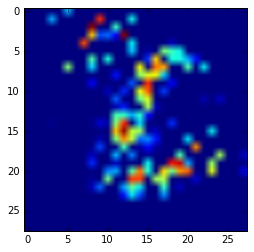

Iteration 23000


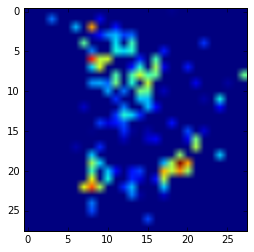

Iteration 24000


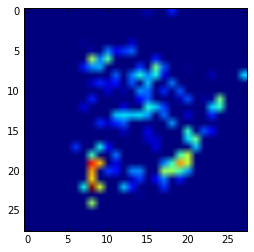

Iteration 25000


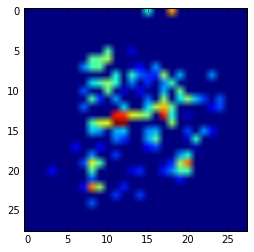

Iteration 26000


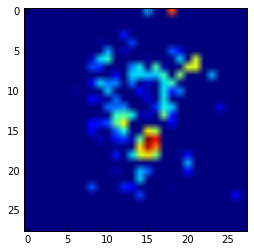

Iteration 27000


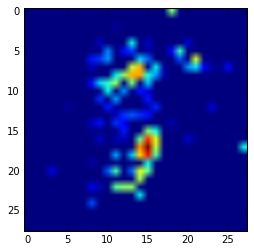

Iteration 28000


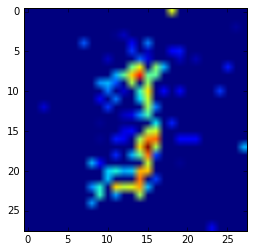

Iteration 29000


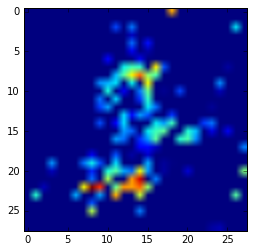

Iteration 30000


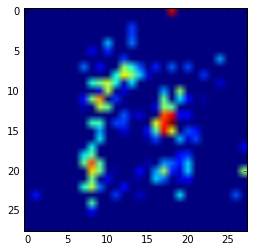

Iteration 31000


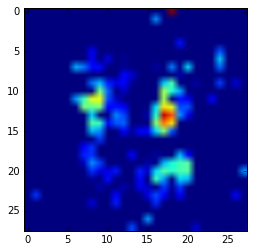

Iteration 32000


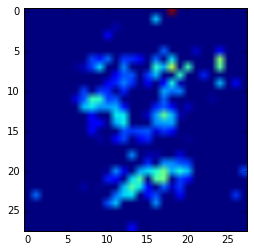

Iteration 33000


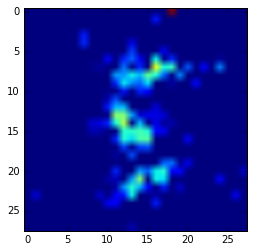

Iteration 34000


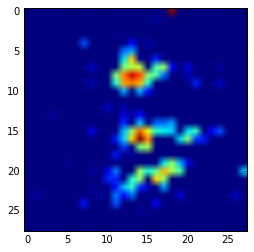

Iteration 35000


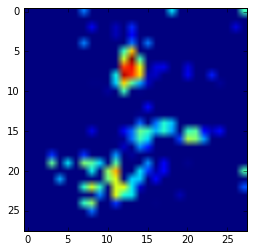

Iteration 36000


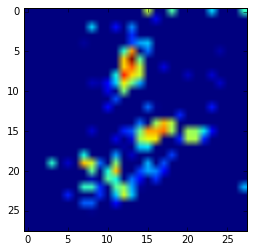

Iteration 37000


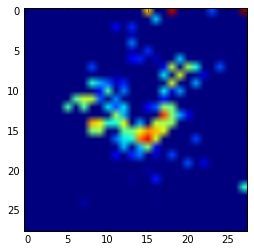

Iteration 38000


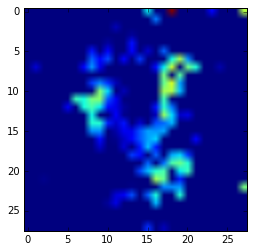

Iteration 39000


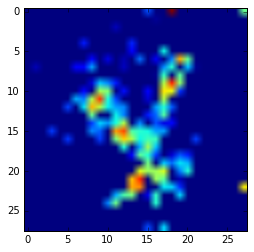

Iteration 40000


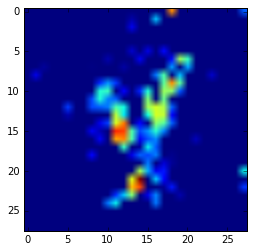

Iteration 41000


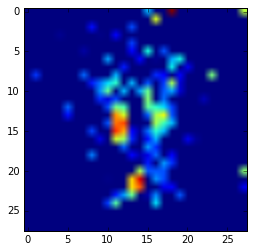

Iteration 42000


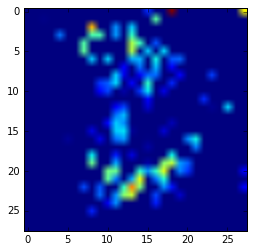

Iteration 43000


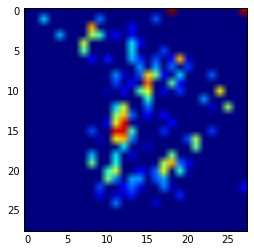

Iteration 44000


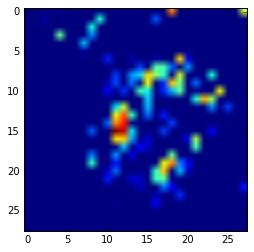

Iteration 45000


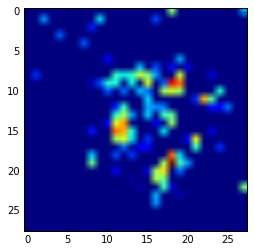

Iteration 46000


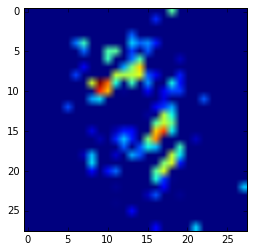

Iteration 47000


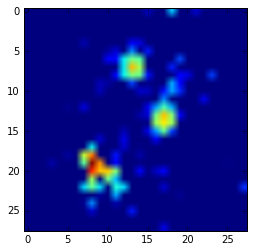

Iteration 48000


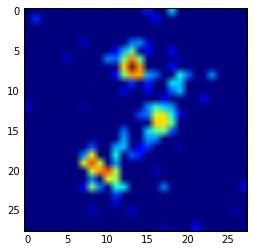

Iteration 49000


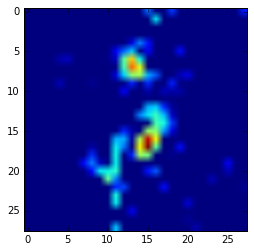

Iteration 50000


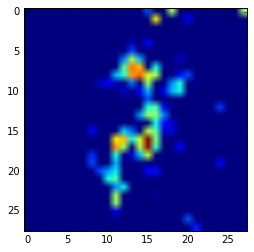

Iteration 51000


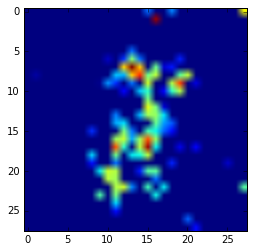

Iteration 52000


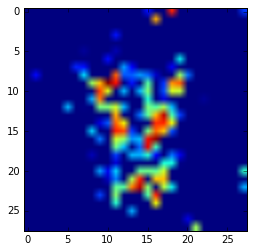

Iteration 53000


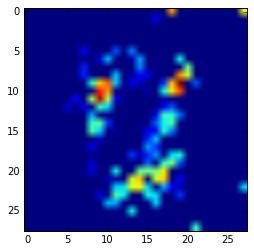

Iteration 54000


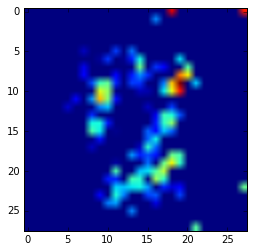

Iteration 55000


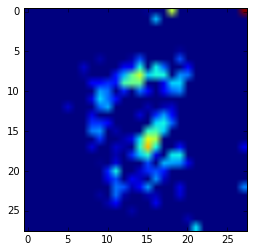

Iteration 56000


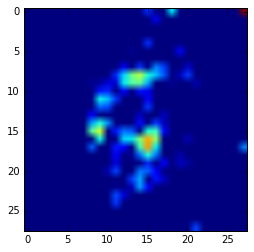

Iteration 57000


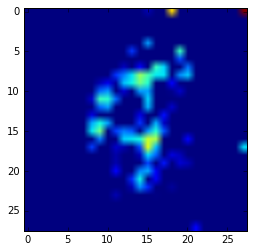

Iteration 58000


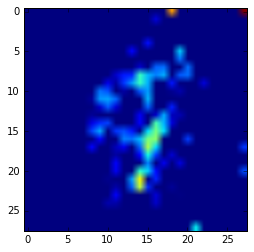

Iteration 59000


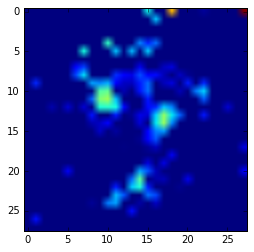

TESTING


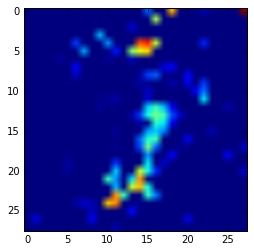

In [27]:
ITERS, BATCH_SIZE = 60000, 100
for i in range(ITERS):
    if i % 1000 == 0:
        print('Iteration %d' % (i))
        input_ = Variable(torch.Tensor(np.random.randn(INPUT)))
        img = gen_model(input_).data.numpy()[0]
        plt.imshow(img)
        plt.show()
    train_disc(BATCH_SIZE)
    train_gen(BATCH_SIZE)
print('TESTING')
input_ = Variable(torch.Tensor(np.random.randn(INPUT)))
img = gen_model(input_).data.numpy()[0]
plt.imshow(img)
plt.show()

Iteration 60000


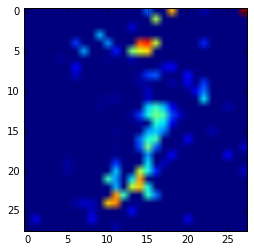

Iteration 61000


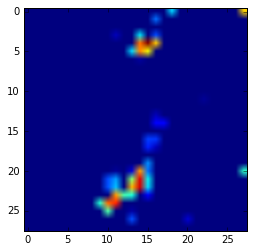

Iteration 62000


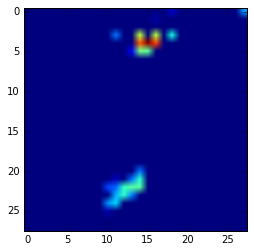

Iteration 63000


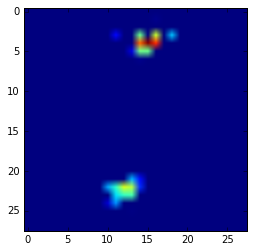

Iteration 64000


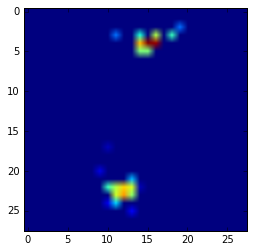

Iteration 65000


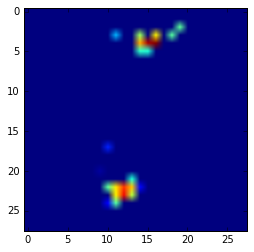

Iteration 66000


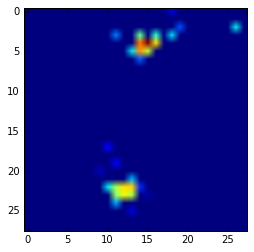

Iteration 67000


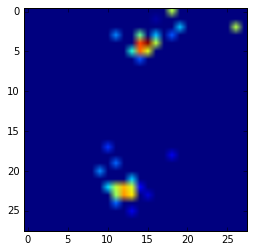

Iteration 68000


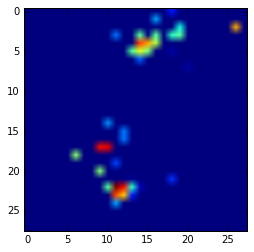

Iteration 69000


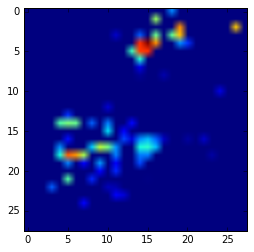

Iteration 70000


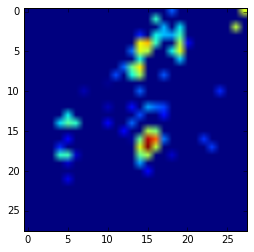

Iteration 71000


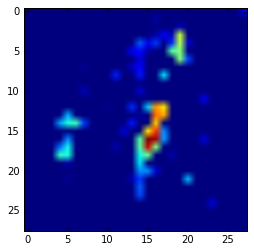

Iteration 72000


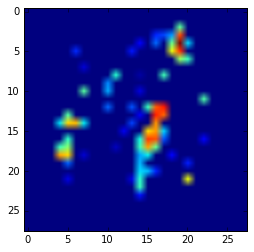

Iteration 73000


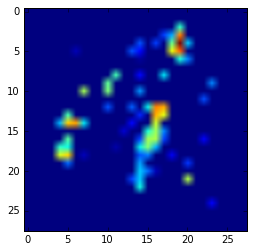

Iteration 74000


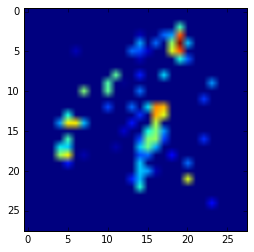

Iteration 75000


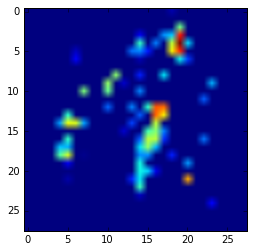

Iteration 76000


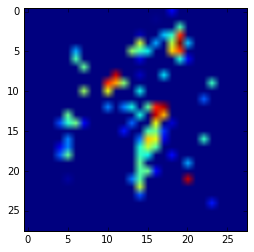

Iteration 77000


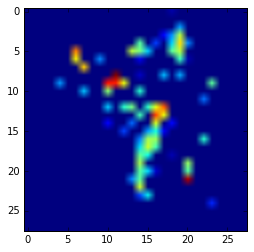

Iteration 78000


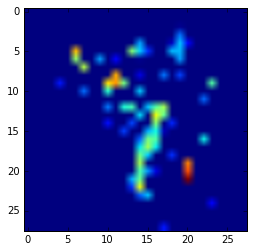

Iteration 79000


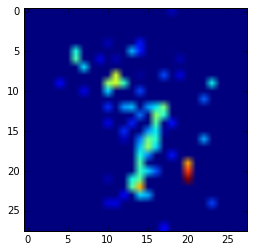

Iteration 80000


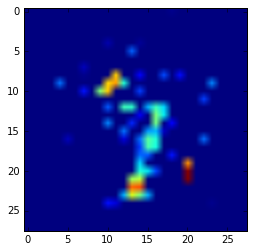

Iteration 81000


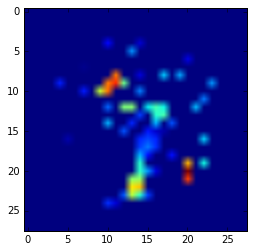

Iteration 82000


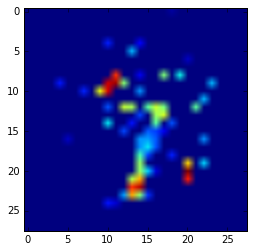

Iteration 83000


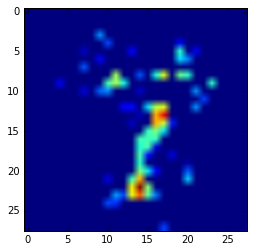

Iteration 84000


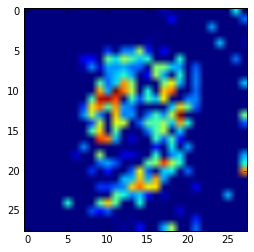

Iteration 85000


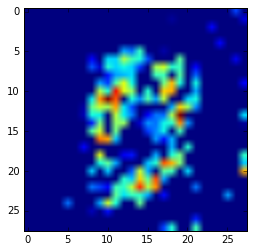

Iteration 86000


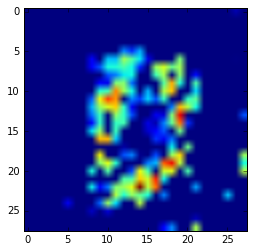

Iteration 87000


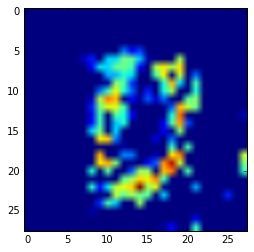

Iteration 88000


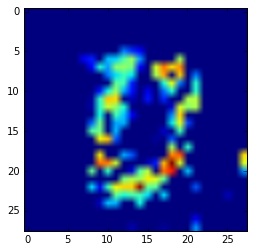

Iteration 89000


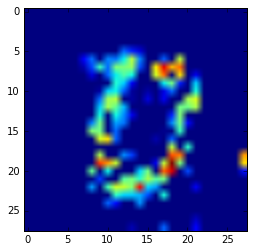

TESTING


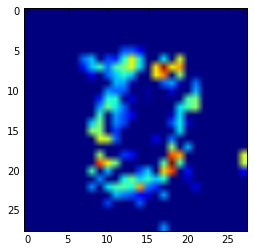

In [28]:
ITERS_2 = ITERS + 30000
batch_size = 100
for i in range(ITERS, ITERS_2):
    if i % 1000 == 0:
        print('Iteration %d' % (i))
        input_ = Variable(torch.Tensor(np.random.randn(INPUT)))
        img = gen_model(input_).data.numpy()[0]
        plt.imshow(img)
        plt.show()
    train_disc(BATCH_SIZE)
    train_gen(BATCH_SIZE)
print('TESTING')
input_ = Variable(torch.Tensor(np.random.randn(INPUT)))
img = gen_model(input_).data.numpy()[0]
plt.imshow(img)
plt.show()